In [1]:
#import import_ipynb
#import imreduction
#import imfit
import sys
import numpy as np
import matplotlib.pyplot as plt #dumped imageio and tifffile packages and used matplotlib to read TIFF files

import scipy.signal as signal

from lmfit import Model
from lmfit.models import GaussianModel, SkewedGaussianModel, LorentzianModel, VoigtModel
from scipy.signal import savgol_filter


%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

import warnings
warnings.filterwarnings("ignore")
#%%writefile image_analysis.py

In [2]:
class Image:
    
    def __init__(self, image):
        self.raw = image
        self.shape= image.shape
        self.x_size= image.shape[0]
        self.y_size= image.shape[1]
        self.subtracted_data= np.array([[0 for y in range(self.y_size)] for x in range(self.x_size)])
        self.profile_x= [0 in range (self.x_size)]
        self.profile_y= [0 in range (self.y_size)]
        self.offset_x= 0 
        self.offset_y= 0
        
    def subtract_bg(self,bg):
        print("Subtracting background...")
        if (bg.shape == self.shape): 
            for i in range(self.x_size):
                for j in range (self.y_size):
                    if ((self.raw[i][j]>bg[i][j]).all() and (bg[i][j]>=0).all() and (self.raw[i][j]>=0).all()):
                        self.subtracted_data[i][j]= self.raw[i][j]-bg[i][j]
                    elif (bg[i][j]<0):
                        self.subtracted_data[i][j]= 0
            return self.subtracted_data
        else:
            print("Error: Background image size does not match data size.")
    
    def get_profile(self):
        print("Getting y-axis profile...")
        #PROFILE IN Y
        for i in range(self.y_size): #loop over all y
            sum=0
            for j in range(self.x_size): #loop over all x for each y: gives one number
                sum=sum + self.subtracted_data[j][i]
            self.profile_y.append(sum)
        self.offset_y= np.mean(self.profile_y[1:5])
        self.profile_y=self.profile_y[1:]- self.offset_y

        
     
        #PROFILE IN X
        print("Getting x-axis profile...")
        for i in range(self.x_size): #loop over all x
            sum=0
            for j in range(self.y_size): #loop over all y for each x: gives one number
                sum=sum + self.subtracted_data[i][j]
            self.profile_x.append(sum)
        self.offset_x=np.mean(self.profile_x[1:5])
        self.profile_x=self.profile_x[1:]-self.offset_x
    


In [81]:
#!{sys.executable} -m pip install seaborn

For now I will import the images in bunch into a list.
Eventually this needs to automatically import the new saved images and append them into the list, or have a drop down menu in a GUI for user to select files to analyze.

In [3]:
##Can I import based on date and viewer from image details?
im=[0 for i in range(0,20)]
i=0
for j in range (15,35):
    im[i]=plt.imread('tiff_files/Tune1'+str(j)+'_07722018_viewer_D1542_001.tiff')
    i+=1

bg=plt.imread('tiff_files/Tune114_background_003.tiff') #background image


In [106]:
im[0]=plt.imread('tiff_files/071918_D1542_overnight_nominal__294.tiff')
bg=plt.imread('tiff_files/071918_D1542_overnight_nominal__295.tiff')

Subtracting background...
Getting y-axis profile...
Getting x-axis profile...


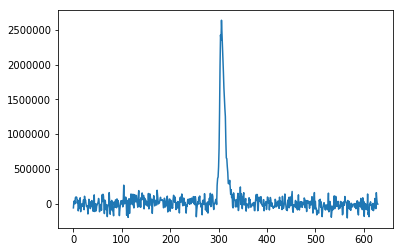

In [4]:
image=Image(im[0])
image.subtract_bg(bg)
image.get_profile()
y = np.arange(image.y_size)
x = np.arange(image.x_size)


prof_y=np.array(image.profile_y[1:]-image.profile_y[1]) 
#prof_x=np.array(image.profile_x[1:]-image.profile_x[1]) 

plt.plot(image.profile_y)
plt.show()

In [5]:
def findMid(profile):
    sum_total=sum(profile)
    for i in range(len(profile)):
        sumInt=sum(profile[0:i])
        frac=sumInt/sum_total
        if (frac>0.49 and frac<0.51):
            print("Case 1. Index: ", i)
            return i
        elif (frac>0.48 and frac<0.52):
            print("Case 2. Index: ", i)           
            return i
        elif (frac>0.46 and frac<0.54):
            print("Case 3. Index: ", i)      
            return i
        else:
            print("Middle is too far out.")

In [6]:
def skewedgauss_fit(profile, x):
    gauss1 = SkewedGaussianModel()
    params_1 = gauss1.guess(profile, x=x)

    mod= gauss1 
    output = mod.fit(profile, params_1, x=x)
    
    #fig, gridspec = output.plot(data_kws={'markersize': 1})
    
    #find the maximum of the gaussian peak
    peak=np.array(output.best_fit).max()
    peak_index=list(output.best_fit).index(peak)
    #find the center of the distribution
    center_param=np.array(output.params['center'])
    #fwhm=np.array(output.params['fwhm'])
    
    #find the mid point that separates two equal amounts of data
    halfp= findMid(np.array(output.best_fit))
    print(halfp)
    #this mid point will be the 'effective center' of our beam spot
    #because this will make it easier to compare to the BCM data and it distributes the beam equally over the center
    return halfp


    

In [7]:
def gauss_fit(profile, x):
    gauss1 = GaussianModel()
    params_1 = gauss1.guess(profile, x=x)

    mod= gauss1 
    output = mod.fit(profile, params_1, x=x)

    #fig, gridspec = output.plot(data_kws={'markersize': 1})
    halfp= findMid(np.array(output.best_fit))
    return halfp


    

In [8]:
def doublegauss_fit(profile, x):
    gauss1 = GaussianModel(prefix='g1_') 
    gauss2= GaussianModel(prefix='g2_')

    params_1 = gauss1.make_params(amplitude=250000,center=145, sigma=1)
    params_2 = gauss2.make_params(amplitude=100000, center=170, sigma=1)
    pars = params_1.update(params_2)
#
#   
    mod= gauss1 + gauss2 
    output = mod.fit(profile, params_1, x=x)

    #fig, gridspec = output.plot(data_kws={'markersize': 1})
    #g1_c, g2_c=[np.array(output.params['g1_center']), np.array(output.params['g2_center'])]
    #g1_a, g2_a= [output.params['g1_amplitude'], output.params['g2_amplitude']]
    
    #if (g1_a>g2_a):
     #   print(g1_c)
      #  return g1_c
    #elif (g2_a>g1_a):
     #   print(g2_c)
      #  return g2_c
    #else:
     #   print("Fit is weird.")
    halfp=findMid(np.array(output.best_fit))
    return halfp


    

In [9]:
def doubleSgauss_fit(profile, x):
    gauss1 = GaussianModel(prefix='g1_') #SkewedGaussianModel(prefix='g1_')
    gauss2= SkewedGaussianModel(prefix='g2_')

    params_1 = gauss1.make_params(amplitude=300000,center=300, sigma=1)
    params_2 = gauss2.make_params(amplitude=100000, center=170, sigma=1)
    pars = params_1.update(params_2)
    
#   

    mod= gauss1 + gauss2 
    output = mod.fit(profile, params_1, x=x)

    fig = plt.figure(figsize=(15, 15))
    #fig, gridspec = output.plot(data_kws={'markersize': 1})

    #g1_c, g2_c=[np.array(output.params['g1_center']), np.array(output.params['g2_center'])]
    #g1_a, g2_a= [output.params['g1_amplitude'], output.params['g2_amplitude']]
    #if (g1_a>g2_a):
     #   return g1_c
    #elif (g2_a>g1_a):
     #   return g2_c
    #else:
      #  print("Fit is weird.")
    halfp=findMid(np.array(output.best_fit))
    print(halfp)
    return halfp

    

Subtracting background...
Getting y-axis profile...
Getting x-axis profile...
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
middle is too far out.
mi

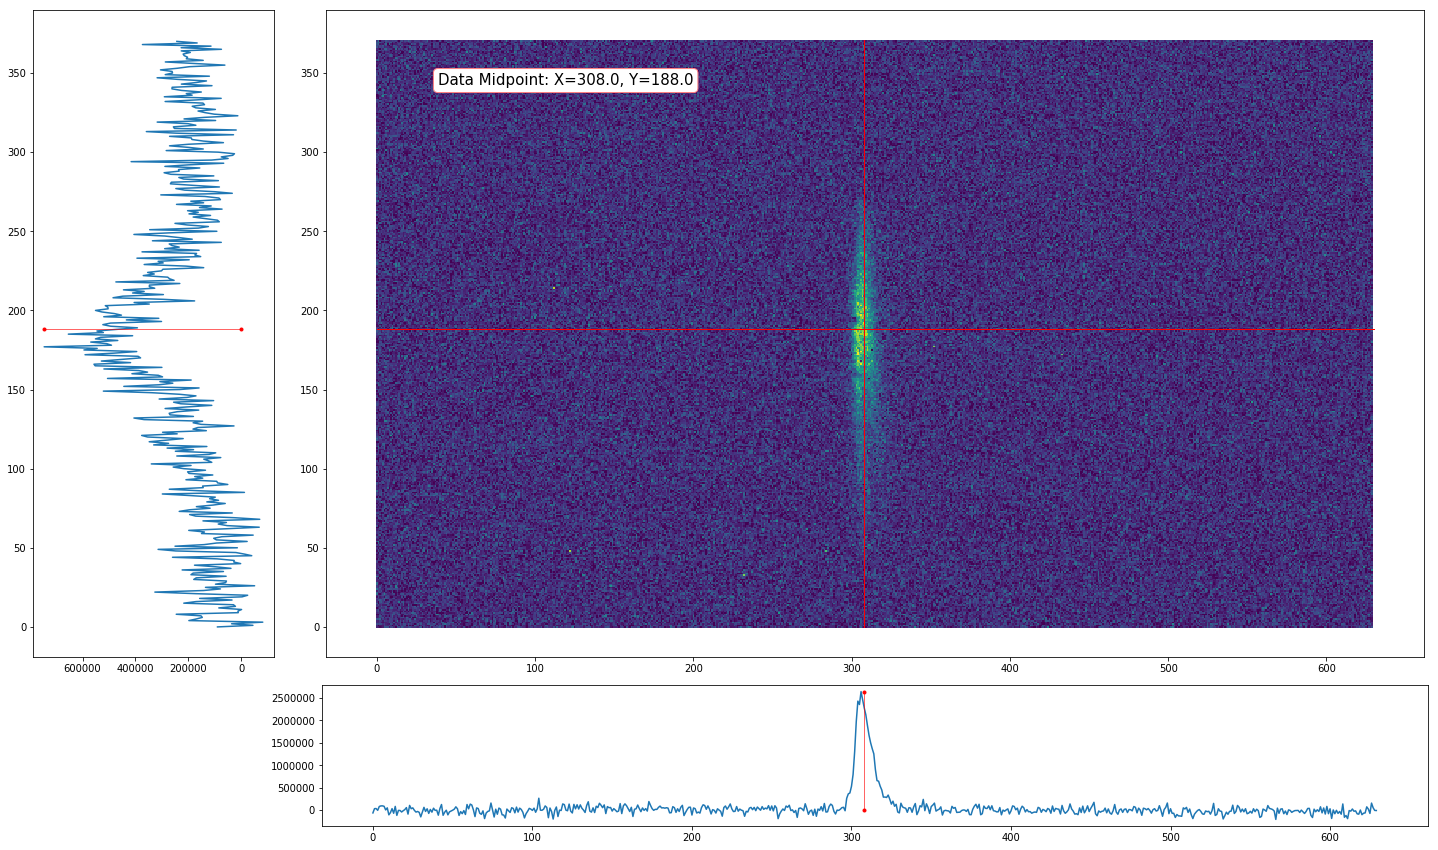

In [10]:

raw_image= im[0]
image=Image(raw_image)
image.subtract_bg(bg)
image.get_profile()
y = np.arange(image.y_size)
x = np.arange(image.x_size)

y_smooth=savgol_filter(image.profile_y, 5, 3)
x_smooth=savgol_filter(image.profile_x, 5, 3)

x_mid=doublegauss_fit(x_smooth,x)
y_mid=skewedgauss_fit(y_smooth,y)

fig = plt.figure(figsize=(25, 15))
grid = plt.GridSpec(5, 5, hspace=0.2, wspace=0.2)
main_ax = fig.add_subplot(grid[:-1, 1:])
print(y_mid, x_mid)
plt.text(200, 350, "Data Midpoint: X=%.1f, Y=%.1f" %(y_mid, x_mid), size=15,
         ha="right", va="top",
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5, 0.5),
                   fc=(1, 1, 1),
                   )
         )
y_hist = fig.add_subplot(grid[:-1, 0], sharey=main_ax)
x_hist = fig.add_subplot(grid[-1, 1:], sharex=main_ax)
 #
 ## scatter points on the main axes
main_ax.imshow(image.subtracted_data)
main_ax.plot([y_mid,y_mid],[0, image.shape[0]],  linewidth=1, color='r')#, marker='-')
main_ax.plot([0, image.shape[1]], [x_mid, x_mid], linewidth=1, color='r')#, marker='-')


x_hist.plot(y, image.profile_y)
x_hist.plot([y_mid,y_mid],[0, image.profile_y.max()],  linewidth=0.6, color='r', marker='.')

y_hist.plot(image.profile_x, x)
y_hist.plot([0, image.profile_x.max()], [x_mid, x_mid], linewidth=0.6, color='r', marker='.')
y_hist.invert_xaxis()
y_hist.invert_yaxis()

plt.savefig('results.png', dpi=100)

In [ ]:
y1=doublegauss_fit(x_smooth,x)
#plt.xlim(70,250)
plt.plot([168,168],[0, prof.max()],  linewidth=0.6, color='r', marker='.', label='peak')
plt.plot([168.2,168.2],[0, prof.max()],  linewidth=0.6, color='b', marker='.', label='center')
plt.plot([181,181],[0, prof.max()],  linewidth=0.6, color='g', marker='.', label='half point')
plt.legend()





In [42]:
print(image.x_size)

371


Below in the fit report I can see that gauss2 and 3's centers are not being detected. This is likely fixed by changing how the parameters are set.

In [ ]:
# can use yerr/residuals to compare residuals between models?

In [ ]:
 g = sns.jointplot(x="x", y="x", data=(im[0])